In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import math

##  Data Preprocessing

In [2]:
# load data
df = pd.read_csv('listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,150097,https://www.airbnb.com/rooms/150097,20230606052736,45084,city scrape,Bed and breakfast in North Hollywood · ★4.96 ·...,Welcome to our guest studio house! private ent...,The house is located in a quiet residential ne...,https://a0.muscache.com/pictures/6793974d-9fb2...,647546,...,4.99,4.90,4.95,NaN,f,4,1,3,0,1.67
1,40667,https://www.airbnb.com/rooms/40667,20230606052736,45084,city scrape,Rental unit in Los Angeles · ★4.30 · 1 bedroom...,"<b>The space</b><br />Nice, quiet master bedr...",NaN,https://a0.muscache.com/pictures/70033015/cb7f...,175264,...,4.64,4.36,4.45,NaN,f,1,0,1,0,0.08
2,109,https://www.airbnb.com/rooms/109,20230606052736,45084,city scrape,Condo in Culver City · 2 bedrooms · 2 beds · 2...,"*** Unit upgraded with new bamboo flooring, ne...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,521,...,4.00,5.00,4.00,NaN,f,1,1,0,0,0.01
3,152514,https://www.airbnb.com/rooms/152514,20230606052736,45084,city scrape,Guesthouse in Manhattan Beach · 1 bedroom · 1 ...,Wake up to the sound of waves crashing on the ...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,733870,...,5.00,5.00,4.00,NaN,f,2,2,0,0,0.01
4,43318,https://www.airbnb.com/rooms/43318,20230606052736,45084,city scrape,Hostel in Los Angeles · ★4.37 · 1 bedroom · 1 ...,Best value in most exciting part of DTLA! Wal...,Little Tokyo is the most vibrant area of downt...,https://a0.muscache.com/pictures/938a66db-d66b...,156094545,...,4.73,4.68,4.53,Exempt - This listing is a hotel or motel,f,14,0,14,0,0.72


In [3]:
#Convert price to numeric
df['price'] = df['price'].astype(int)

In [4]:
#Analyze the distribution of price. Resolve the imbalance data
df['price'].describe()

count    44464.000000
mean       279.030969
std        880.129338
min          0.000000
25%         89.000000
50%        148.000000
75%        250.000000
max      90150.000000
Name: price, dtype: float64

In [5]:
df = df[df['price'] < 500]
df = df[df['price'] > 25]

In [6]:
df['price'].describe()

count    39979.000000
mean       159.886816
std        100.372385
min         26.000000
25%         88.000000
50%        133.000000
75%        206.000000
max        499.000000
Name: price, dtype: float64

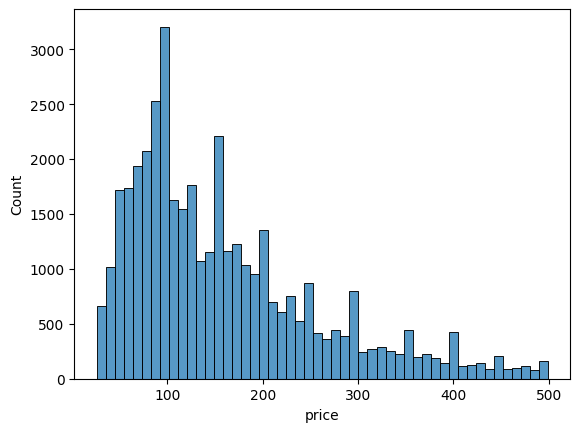

In [7]:
sns.histplot(df['price'], bins=50)
plt.show()

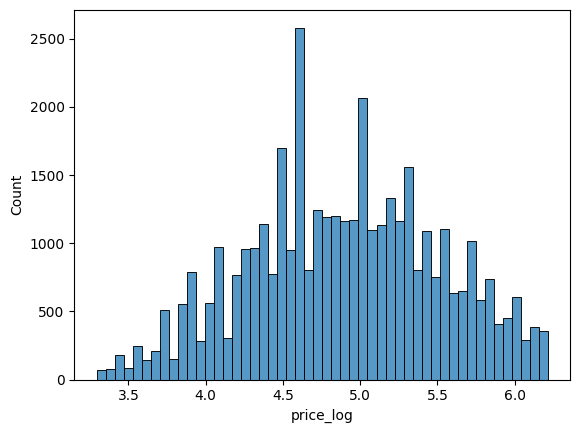

In [8]:
# Depending on the skewness, we might apply a transformation
df['price_log'] = np.log1p(df['price'])
df['price_log']
sns.histplot(df['price_log'], bins=50)
plt.show()

In [9]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [10]:
#selected features bathrooms, bedrooms, accommodates, property type, instant bootability.

features = ['bathrooms', 'bedrooms', 'beds', 'accommodates', 'review_scores_rating',
            'neighbourhood', 'property_type', 'instant_bookable']

In [11]:
#Clean the data
#extract the numbers from the bathroom_text; 
df['bathrooms'] = df['bathrooms_text'].str.extract('(\d+\.*\d*)').astype(float)

In [12]:
df['property_type'].value_counts().head(8)

property_type
Entire rental unit             10776
Entire home                     7683
Private room in home            7298
Entire guesthouse               2405
Private room in rental unit     2172
Entire condo                    1732
Entire guest suite              1296
Entire townhouse                 691
Name: count, dtype: int64

In [13]:
#minimize the number types in property_type for model, choose count > 1000
top_types = df['property_type'].value_counts().index[:7]

df['property_type'] = df['property_type'].apply(lambda x: x if x in top_types else 'Other')

In [14]:
df['property_type'].value_counts()

property_type
Entire rental unit             10776
Entire home                     7683
Private room in home            7298
Other                           6617
Entire guesthouse               2405
Private room in rental unit     2172
Entire condo                    1732
Entire guest suite              1296
Name: count, dtype: int64

In [15]:
df[features].isnull().sum()

bathrooms                 104
bedrooms                14318
beds                      506
accommodates                0
review_scores_rating    10960
neighbourhood           16216
property_type               0
instant_bookable            0
dtype: int64

In [16]:
#resolve missing values
mode1 = df['bedrooms'].mode()
df['bedrooms'].fillna(mode1, inplace=True)
mode2 = df['beds'].mode()
df['beds'].fillna(mode2, inplace=True)
mode3 = df['bathrooms'].mode()
df['bathrooms'].fillna(mode3, inplace=True)
mode4 = df['review_scores_rating'].mode()
df['review_scores_rating'].fillna(mode4,inplace=True)
df.dropna(subset=['neighbourhood'], inplace=True)

In [17]:
df[features].describe()

,bathrooms,bedrooms,beds,accommodates,review_scores_rating
count,23714.000000,14886.000000,23543.000000,23763.000000,18311.000000
mean,1.466960,1.791616,1.988064,3.546438,4.757844
std,0.770915,1.003775,1.323279,2.199134,0.502365
min,0.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,4.720000
50%,1.000000,2.000000,2.000000,3.000000,4.890000
75%,2.000000,2.000000,2.000000,4.000000,5.000000
max,11.500000,18.000000,24.000000,16.000000,5.000000


array([[<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'bedrooms'}>],
       [<Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'accommodates'}>],
       [<Axes: title={'center': 'review_scores_rating'}>, <Axes: >]],
      dtype=object)

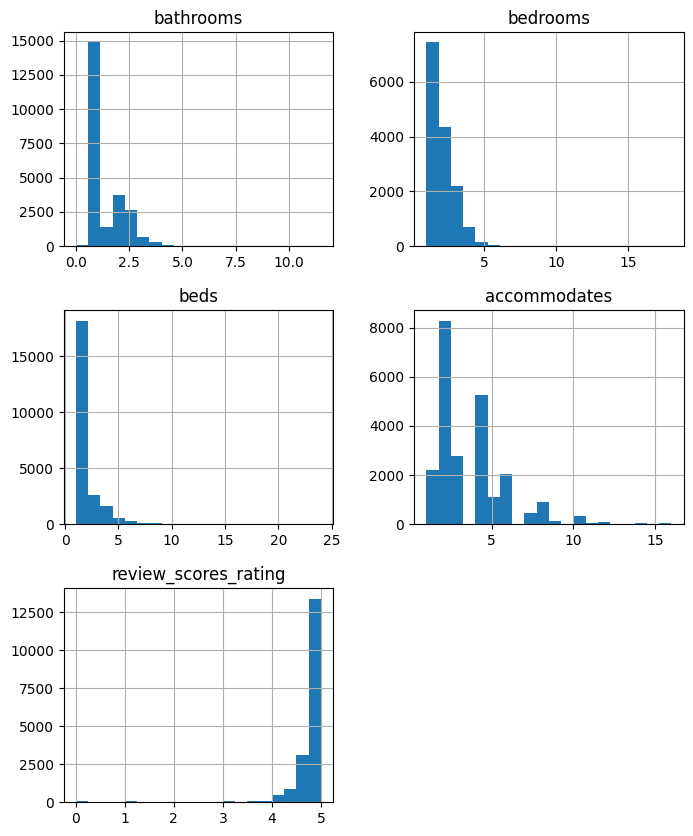

In [18]:
df[features].hist(figsize=(8,10), bins=20)

In [19]:
df = df[df['bathrooms'] < 6 ]
df = df[df['bedrooms'] < 8 ]
df = df[df['beds'] < 10 ]
df = df[df['review_scores_rating'] > 3.5]

array([[<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'bedrooms'}>],
       [<Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'accommodates'}>],
       [<Axes: title={'center': 'review_scores_rating'}>, <Axes: >]],
      dtype=object)

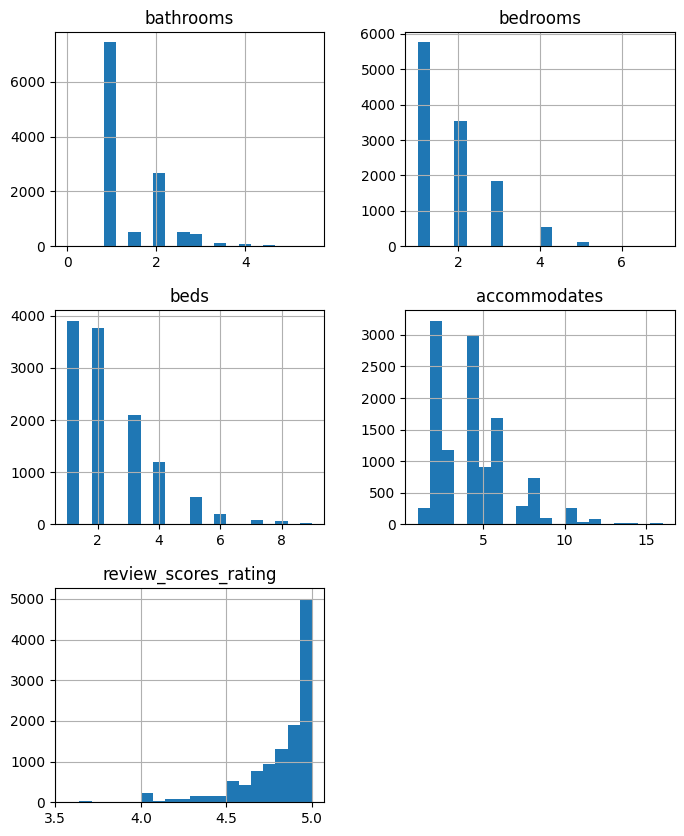

In [20]:
df[features].hist(figsize=(8,10), bins=20)

In [21]:
# recheck null value
df[features].isnull().sum()

bathrooms               0
bedrooms                0
beds                    0
accommodates            0
review_scores_rating    0
neighbourhood           0
property_type           0
instant_bookable        0
dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['property_type'] = label_encoder.fit_transform(df['property_type'])

df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])

df['neighbourhood'] = label_encoder.fit_transform(df['neighbourhood'])

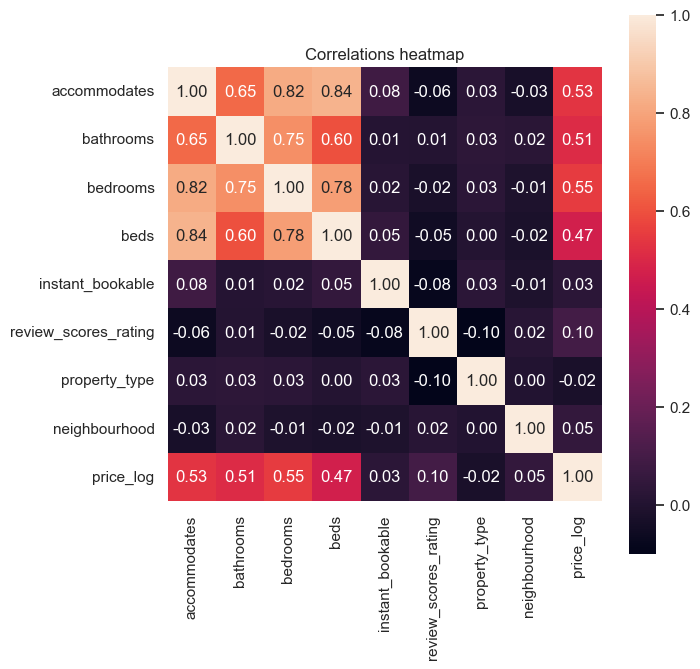

In [23]:
cols = ['accommodates','bathrooms','bedrooms','beds','instant_bookable',
        'review_scores_rating','property_type','neighbourhood', 'price_log']

#Find out correlation between columns and plot
corrs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

In [24]:
#Split data into train set and test set

X = df[features]
y = df['price_log']  # Using the log transformed price as target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)


In [25]:
#Perform necessary categorical data encoding and feature scaling

# 'property_type', 'instant_bookable', 'neighbourhood' are  
# categorical features label in the last correlation step

numeric_features = ['bathrooms', 'bedrooms', 'beds', 'accommodates','review_scores_rating']

transformers = [
    ('num', StandardScaler(), numeric_features)
]

preprocessor = ColumnTransformer(transformers, remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [26]:
pd.DataFrame(X)

,bathrooms,bedrooms,beds,accommodates,review_scores_rating,neighbourhood,property_type,instant_bookable
0,1.0,1.0,2.0,3,4.96,111,5,0
5,1.0,2.0,2.0,4,4.73,88,3,0
13,1.0,1.0,2.0,4,4.91,88,5,0
14,2.0,2.0,2.0,4,4.64,88,4,0
15,1.0,2.0,1.0,1,4.80,88,3,0
...,...,...,...,...,...,...,...,...
43910,1.0,1.0,1.0,3,5.00,141,3,1
43963,2.0,3.0,4.0,7,5.00,203,4,0
44022,2.0,2.0,2.0,4,5.00,32,4,1
44131,1.0,1.0,2.0,4,5.00,5,3,0


## Regression Modeling

In [27]:
#Multiple Linear Regression

# Train
linear_reg = LinearRegression()
linear_reg.fit(X_train_processed, y_train)

# Predict
y_pred_lr = linear_reg.predict(X_test_processed)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mse_lr)

print(f"Linear Regression RMSE: {rmse_lr}")

Linear Regression RMSE: 0.39663769956297157


In [28]:
# Random Forest
# define hyper parameters
param_grid = {
    'n_estimators': [10, 50, 100,200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state = 0)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train_processed, y_train)


best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


best_rf = RandomForestRegressor(**best_params, random_state=0)
best_rf.fit(X_train_processed, y_train)


y_pred_rf = best_rf.predict(X_test_processed)


Best Parameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = math.sqrt(mse_rf)

print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 0.3610424713287635


In [30]:
## Decision Tree
param_grid2 = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['friedman_mse']  # 对于DecisionTreeRegressor; 对于DecisionTreeClassifier, 可以使用 ['gini', 'entropy']
}
tree = DecisionTreeRegressor(random_state = 0)  # 或 DecisionTreeClassifier
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid2, 
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [31]:
best_tree = DecisionTreeRegressor(**best_params)  # 或 DecisionTreeClassifier
best_tree.fit(X_train_processed, y_train)
y_pred_dt = best_tree.predict(X_test_processed)


mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = math.sqrt(mse_dt)
print(f"Decision Tree RMSE: {rmse_dt}")


Decision Tree RMSE: 0.37782933333727325


In [32]:
#SVR
param_grid3 = {
    'C': [ 1, 10],
    'kernel': ['rbf'],
    'gamma': ['auto', 1]
}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid3, 
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [33]:
best_svr = SVR(**best_params)
best_svr.fit(X_train_processed, y_train)
y_pred_svr = best_svr.predict(X_test_processed)

mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = math.sqrt(mse_svr)

print(f"Support Vector Regression RMSE: {rmse_svr}")


Support Vector Regression RMSE: 0.36157330071550314


## Prediction

In [34]:
#best model is random forest
data = {
    'bathrooms': [2],
    'bedrooms': [3],
    'beds': [1], #choose the mode
    'accommodates': [5],
    'review_scores_rating': [5], #choose the mode
    'neighbourhood': [88], # choose the mode
    'property_type': [2],#Entire home/apt = others = 2
    'instant_bookable': [1] # True = 1
}

df_new_listing = pd.DataFrame(data)

predicted_price = best_rf.predict(df_new_listing)
price = np.expm1(predicted_price)

print(f"Predicted price for the listing: ${price[0]:.2f}")


Predicted price for the listing: $321.10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
